# Aprendizado de Máquina

### Teste paramétricos para elaboração de Stacking de modelo de Gradient Boosting com Rede Neural. Ainda em fases de teste

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import requests
import gzip
import plotly.graph_objects as go

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss

In [3]:
from numpy import ravel
import sklearn.model_selection
from sktime.forecasting.compose import make_reduction
from skopt import gp_minimize
from lightgbm import LGBMRegressor
from statsmodels.tsa.filters.hp_filter import hpfilter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [4]:
from sktime.forecasting.naive import NaiveForecaster
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

In [6]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [7]:
SEED = 4

In [8]:
url = 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv.gz?raw=true'
r = requests.get(url, allow_redirects=True)
open('data.csv.gz','wb').write(r.content)
gz = gzip.open('data.csv.gz')
df = pd.read_csv(gz)

## Validação de Modelos

In [9]:
data = df.query("state == 'AM'").groupby('date').sum()
data.index = pd.to_datetime(data.index)
data.index.freq = 'D'
data.drop(columns=['epi_week', 'ibgeID', 'cod_RegiaoDeSaude', 'deaths', 'totalCases'], inplace=True)
data = data.iloc[:,:2]

In [10]:
def to_zero(x):
    if x < 0:
        return 0
    return x

In [11]:
data['newDeaths'] = data['newDeaths'].apply(to_zero)
data['newCases'] = data['newCases'].apply(to_zero)

In [12]:
for col in data.columns:
    data['log' + "_" + col] = np.log(data[col] + 1)

In [13]:
for col in data.columns[:2]:
    cycle, trend = hpfilter(data[col])
    data[col + '_' + 'cycle'] = cycle.round()
    data[col + '_' + 'trend'] = trend.round()

In [14]:
data['newDeaths_trend'] = data['newDeaths_trend'].apply(to_zero)
data['newCases_trend'] = data['newCases_trend'].apply(to_zero)
data['dia_da_semana'] = data.index.day_name()
data.reset_index(inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [15]:
data_from_newCases = data[['date', 'newCases', 'log_newCases', 'newCases_trend','newCases_cycle', 'dia_da_semana']]
data_from_newCases['MA_7'] = data_from_newCases['newCases'].rolling(7).mean()
data_from_newCases = data_from_newCases.fillna(0)
data_from_newCases['newCases_trend'] = np.log(data_from_newCases['newCases_trend'] + 1)

<ipython-input-15-92fb3eb7e990>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_from_newCases['MA_7'] = data_from_newCases['newCases'].rolling(7).mean()


In [16]:
data_from_newCases

,date,newCases,log_newCases,newCases_trend,newCases_cycle,dia_da_semana,MA_7
0,2020-03-13,2,1.098612,0.000000,10.0,Friday,0.000000
1,2020-03-14,0,0.000000,0.000000,6.0,Saturday,0.000000
2,2020-03-15,0,0.000000,0.000000,5.0,Sunday,0.000000
3,2020-03-16,0,0.000000,0.000000,3.0,Monday,0.000000
4,2020-03-17,0,0.000000,0.000000,2.0,Tuesday,0.000000
...,...,...,...,...,...,...,...
397,2021-04-14,820,6.710523,6.629363,64.0,Wednesday,815.428571
398,2021-04-15,893,6.795706,6.609349,152.0,Thursday,805.857143
399,2021-04-16,773,6.651572,6.587550,48.0,Friday,748.857143
400,2021-04-17,701,6.553933,6.563856,-7.0,Saturday,743.714286


In [17]:
max_prediction_length = 14 #14 dias
max_encoder_length = 14 * 4 #usar 8 semanas de histórico
data_from_newCases["time_idx"] = range(1, 1 + len(data_from_newCases['date'])) #time_idx
training_cutoff = data_from_newCases["time_idx"].max() - max_prediction_length

In [18]:
training = TimeSeriesDataSet(
    data_from_newCases[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="newCases",
    group_ids=['time_idx'],
    min_encoder_length=0,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=['dia_da_semana'],
    time_varying_unknown_reals=[
        "newCases",
        "newCases_trend",
        "newCases_cycle",
        'log_newCases',
        'MA_7'
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    )

C:\Users\heylu\miniconda3\lib\site-packages\pytorch_forecasting\data\timeseries.py:517: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [19]:
validation = TimeSeriesDataSet.from_dataset(training, data_from_newCases, predict=True, stop_randomization=True)

KeyError: "Unknown category '664' encountered. Set `add_nan=True` to allow unknown categories"

In [63]:
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [64]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

125.12245178222656

In [66]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [67]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
Number of parameters in network: 19.0k


In [68]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 35    
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 0.041686938347033554


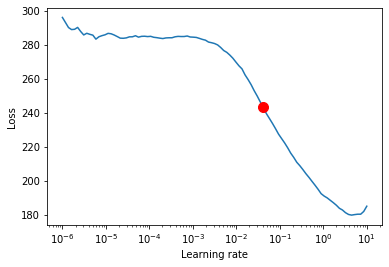

<ipython-input-69-d9a296a1fb7d>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [69]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()